<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>








<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/multivariate_geostats/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Multivariate Geostats: Beyond classical Clustering and Regression

## Getting Ready

### The Data


Let's use the data from Peru previously seen:

In [2]:
import geopandas as gpd

peruDataLink="https://github.com/meade68/DACSS_690D_Week12/raw/refs/heads/main/DATA/PeruMaps.gpkg"
DisMap=gpd.read_file(peruDataLink,layer='good_geom')

The "good_geom" layer is a new layer we had to use because it show no relevant topological issues (we had previously used one with some issues not detected).

Rememeber this "good map" has isolates:

In [3]:
from libpysal.graph import Graph

DisMap_adjaceny=Graph.build_contiguity(DisMap)
DisMap_adjaceny.isolates

Index([51, 58], dtype='int64', name='focal')

Let's subset now, and avoid future warnings:

In [6]:
DisMap.drop(index=DisMap_adjaceny.isolates,inplace=True)
DisMap.reset_index(drop=True,inplace=True)

### Preprocessing

First check CRS:



In [7]:
DisMap.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# reprojecting
DisMap=DisMap.to_crs(32718)

We have these columns:

In [9]:
DisMap.columns

Index(['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'ubigeo', 'Poblacion',
       'IDH2019', 'Educ_sec_comp2019_pct', 'NBI2017_pct',
       'Viv_sin_serv_hig2017_pct', 'geometry'],
      dtype='object')

Let me select the columns we will use:

In [10]:
selected_variables = ['Educ_sec_comp2019_pct','NBI2017_pct', 'Viv_sin_serv_hig2017_pct']

Let's see the descriptives, paying attention to **range**:

In [11]:
DisMap[selected_variables].describe()

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1869.000000,1869.000000,1869.000000
mean,55.765803,38.576190,17.089995
std,15.722465,18.273604,16.367167
min,11.974433,1.100000,0.000000
25%,44.465149,24.900000,5.000000
50%,57.043976,35.300000,12.100000
75%,68.212665,49.200000,24.100000
max,91.744878,99.400000,96.500000


Let me check their monotony:

In [12]:
DisMap[selected_variables].corr()

,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
Educ_sec_comp2019_pct,1.000000,-0.427936,-0.201650
NBI2017_pct,-0.427936,1.000000,0.664441
Viv_sin_serv_hig2017_pct,-0.201650,0.664441,1.000000


Clearly, 'Educ_sec_comp2019_pct' represents a diffent monotonic direction than the rest, because it measures a positive concept, while the others measure negative ones.

Here, we can reverse the values of *Educ_sec_comp2019_pct*:

In [13]:
## from complete to 'incomplete'
DisMap['Educ_sec_incomp2019_pct']=100-DisMap['Educ_sec_comp2019_pct']

Let's verify the presence of outliers:

<Axes: >

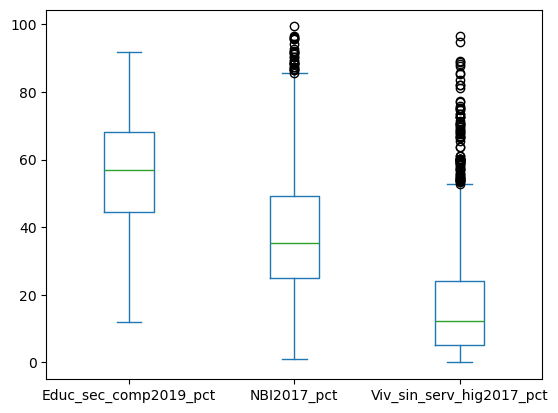

In [14]:
DisMap[selected_variables].plot(kind='box')

The presence of outliers forces us to choose a robust transformation to produce columns ready for clustering techniques:

$$Z_{\text{robust}} = \frac{X - \text{Median}}{\text{MAD}}$$

1.  **Median:** Unlike the mean, the median is minimally affected by outliers.
2.  **Median Absolute Deviation (MAD):** This is a robust measure of statistical dispersion. It is calculated by finding the median of the absolute deviations from the median: $\text{MAD} = \text{Median}(|X - \text{Median}|)$.

I will use **mad()** from scipy with **scale='normal'**. The `scale='normal'` argument ensures the resulting MAD value is scaled to be comparable to the standard deviation ($\sigma$). This ensures your new robust scores are on a familiar scale (most values between $-3$ and $+3$) and are suitable for our clustering algorithm.

Notice regression **needs not** this standardization.

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation as mad

# --- Function to Perform Robust Standardization (Z-score via Median and MAD) ---
def robust_score(series):
    # 1. Calculate the Median
    median_val = series.median()
    # 2. Calculate the Median Absolute Deviation (MAD)
    mad_val = mad(series, scale='normal') #for comparability with Zs
    # 3. Apply the Robust Formula
    return (series - median_val) / mad_val

Let's rename the variables to used during clustering:

In [16]:
deficit_cols = ['Educ_sec_incomp2019_pct','NBI2017_pct', 'Viv_sin_serv_hig2017_pct']

clusterNames=['Education_deficit','BasicNeeds_deficit','Sanitation_deficit']
DisMap[clusterNames]=DisMap[deficit_cols].apply(robust_score)
DisMap[clusterNames]

,Education_deficit,BasicNeeds_deficit,Sanitation_deficit
0,-1.252926,-1.124150,-0.721547
1,0.379491,-0.098003,1.043106
2,0.044232,-0.524603,-0.258816
3,-0.889000,2.023469,4.352812
4,-0.433078,-0.386246,-0.078429
...,...,...,...
1864,-0.496733,0.000000,-0.133329
1865,-0.314010,0.714844,1.905826
1866,-0.674490,-0.380481,-0.235287
1867,-0.671386,0.167181,-0.250973


In [17]:
# as a result:
DisMap[clusterNames].corr()

,Education_deficit,BasicNeeds_deficit,Sanitation_deficit
Education_deficit,1.000000,0.427936,0.201650
BasicNeeds_deficit,0.427936,1.000000,0.664441
Sanitation_deficit,0.201650,0.664441,1.000000


Let's rename the original variables for regression section:

In [18]:
#prepare the dict
regressionNames=[col+'_pct' for col in clusterNames]
changes={old:new for old,new in zip(deficit_cols,regressionNames)}
changes

{'Educ_sec_incomp2019_pct': 'Education_deficit_pct',
 'NBI2017_pct': 'BasicNeeds_deficit_pct',
 'Viv_sin_serv_hig2017_pct': 'Sanitation_deficit_pct'}

In [19]:
DisMap.rename(columns=changes,inplace=True)

### The SEED

Several functions will use some random process. I will set a seed here, that you have use should you wnat to get the same results I got.

In [20]:
import numpy
RANDOM_SEED = 12345
numpy.random.seed(RANDOM_SEED)

## Clustering

### Conventional Clustering

Conventional clustering is a basic machine learning technique used to group a set of data points into clusters so that points within the same cluster are more similar to each other than to those in other clusters. Think of it as sorting objects into piles based on how alike they are.

In this case, I will use the three variables to create clusters of **districts**. There are several options you may have seen before, like KMeans,KMedoids, and Hierarchical (divissive/agglomerative).




#### KMeans

We can easily compute them like this:

In [21]:
from sklearn.cluster import KMeans

K_target = 5

# as simple as:
DisMap['deficit_k5'] = KMeans(n_clusters=K_target,random_state=RANDOM_SEED).fit_predict(DisMap[clusterNames])

In [22]:
# see distribution of districts
DisMap["deficit_k5"].value_counts()

deficit_k5
1    534
2    495
4    440
3    294
0    106
Name: count, dtype: int64

## Regionalization: Spatial Clustering

Regionalization is the process of **clustering cases into contiguous regions** based on shared characteristics. In our work, the goal is to create socio-economic zones where districts within a zone are similar to each other and geographically connected. This way Spatial clustering tries building regions that are both **statistically coherent**  and **geographically coherent**. A good regionalization  makes the results useful for regional planning, resource allocation, and targeted policy intervention.

> **The neigborhood matrix**: Spatial clustering requires the input of this matrix. Notice we will compute two versions.

In [23]:
# for mos cases except spatial kmeans
peru_perim_graph = Graph.build_contiguity(DisMap, by_perimeter=True)
peru_perim_graph=peru_perim_graph.transform("r")

# for spatial kmeans
from libpysal.weights import W # Import W for the conversion
peru_perim = peru_perim_graph.to_W()
peru_perim.transform = "r"

Notice we have two matrices:

In [24]:
type(peru_perim_graph),type(peru_perim)

(libpysal.graph.base.Graph, libpysal.weights.weights.W)

They have the same information, but they are different data structures.


### 1. The K-means with contiguity: Regional K-Means Heuristic

We can easily get these clusters using (notice here we use **peru_perim**):

In [25]:
from spopt.region import RegionKMeansHeuristic as RKMeans

RKMeans_model = RKMeans(data=DisMap[clusterNames].values,
                        n_clusters=K_target,
                        seed=RANDOM_SEED,
                        w=peru_perim,drop_islands=True)
# computing
RKMeans_model.solve()

From here, we can add that column to our data:

In [26]:
DisMap['deficit_k5R'] = RKMeans_model.labels_
DisMap["deficit_k5R"].value_counts()

deficit_k5R
0    438
1    390
2    364
4    356
3    321
Name: count, dtype: int64

### 2. The Swapping game: AZP (A Priori Zoning Problem)

AZP is one of the earliest and most direct algorithms for spatial clustering. We can easily compute it like this (notice **w=peru_perim_graph**)

In [28]:
from spopt.region import AZP

azp_model = AZP(
    gdf=DisMap,
    w=peru_perim_graph,
    attrs_name=clusterNames,
    n_clusters=K_target,
    random_state=RANDOM_SEED)
# computing
azp_model.solve()

New column with labels:

In [30]:
DisMap['deficit_azpR'] = azp_model.labels_
DisMap["deficit_azpR"].value_counts()

deficit_azpR
0.0    522
3.0    499
1.0    461
4.0    377
2.0     10
Name: count, dtype: int64

### 3. The Smart gardener: Skater

The "Spatial 'K'luster Analysis by Tree Edge Removal" is avery interesting model based on the Minimum Spanning Tree (take a look: [MST](https://colab.research.google.com/drive/13KamN7ITezGsojlLYiRPNCSYEnx9qx01?usp=sharing)).

We can easily compute this regression like this:

In [31]:
from spopt.region import Skater

skater_model = Skater(
    gdf=DisMap,
    w=peru_perim_graph,
    attrs_name=clusterNames,
    n_clusters=K_target
)
# computing
skater_model.solve()


The cluster as a new column:

In [32]:
DisMap['deficit_skaterR'] = skater_model.labels_
DisMap["deficit_azpR"].value_counts()

deficit_azpR
0.0    522
3.0    499
1.0    461
4.0    377
2.0     10
Name: count, dtype: int64

## Clustering vs Regionalization

### Geographical Coherence:

Here we can compute two measures of **COMPACTNESS**

* **The isoperimetric quotient (IPQ)**. This compares the area of the region to the area of a circle with the same perimeter as the region.
* **Convex hull ratio (CHR)**. The CHR is simply the division of the area of the cluster by the area of its convex hull.

In [36]:
from esda import shape as compactness

# columns with cluster labels
cluster_types_to_evaluate = ["deficit_k5","deficit_k5R","deficit_azpR","deficit_skaterR"]

# List to store the results
means_IPQCHR = []

for cluster_type in cluster_types_to_evaluate:
    # 1.disolving for both
    regions = DisMap[[cluster_type, "geometry"]].dissolve(by=cluster_type)

    # 2. Compute IPQ and CHR (at the dissolved regions level)
    ipqs = compactness.isoperimetric_quotient(regions)
    chullr = compactness.convex_hull_ratio(regions)

    # 3. Append the means to 'means_IPQCHR'
    means_IPQCHR.append((cluster_type, ipqs.mean(), chullr.mean()))

# Re-arrange the scores into a dataframe for display
colNames = ["cluster type", "Mean IPQ", "Mean CHR"]
comparisson_geo = pd.DataFrame(means_IPQCHR, columns=colNames).set_index("cluster type")


Both **Isoperimetric Quotient (IPQ)** and **Convex Hull Ratio (CHR)** are metrics used to assess the **spatial compactness** of a polygon (like a geographic region), but they quantify compactness based on different geometric ideals.

### Statistical Coherence

Here we can compute:
* The **Silhouette (SIL) Score** for HOMOGENEITY
* The  **Calinski-Harabasz (CH) Score** for HETEROGENEITY

In [37]:
from sklearn import metrics

scores_CHSIL = []

for cluster_type in cluster_types_to_evaluate:
    ch_score = metrics.calinski_harabasz_score(
        DisMap[clusterNames],# using scaled variables
        DisMap[cluster_type])# using these labels
    sil_score = metrics.silhouette_score(
        DisMap[clusterNames],DisMap[cluster_type]) #same as above

    # appending
    scores_CHSIL.append((cluster_type, ch_score,sil_score))


# re-arrange the scores into a dataframe for display
colNames=["cluster type", "CH score", "SIL score"]
comparisson_stat=pd.DataFrame(scores_CHSIL, columns=colNames).set_index("cluster type")

Let's see the results:

In [38]:
# Concatenate the two DataFrames column-wise (axis=1)
combined_df = pd.concat([comparisson_geo,comparisson_stat],axis=1)

### Define the two levels of the column MultiIndex

# Level 0 (Top Header): Groups the metrics
top_level = ['Geo Coherence'] * 2 + ['Stat Coherence'] * 2
# Level 1 (Metric Name): The original column names
bottom_level = combined_df.columns.tolist()

# Create the MultiIndex
combined_df.columns = pd.MultiIndex.from_arrays([top_level, bottom_level])

# Display the resulting DataFrame
combined_df

Geo Coherence           Stat Coherence          
                     Mean IPQ  Mean CHR       CH score SIL score
cluster type                                                    
deficit_k5           0.005904  0.178057    1129.192309  0.280708
deficit_k5R          0.033134  0.533805     137.945716 -0.035487
deficit_azpR         0.061461  0.524369     105.354901 -0.107834
deficit_skaterR      0.116546  0.677066      90.831494 -0.114347

Considering that **deficit_k5** is the benchmark, we can conclude:


| Cluster type        | Interpretation                                                                                                                                                                                                                                                                                                                                                                |
| ------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **deficit_k5**      | **Statistically strong but spatially meaningless.** The conventional K-Means achieves the best internal homogeneity (highest CH and SIL scores), but its geographic coherence is almost zero (lowest IPQ and CHR). Regions are statistically compact but geographically fragmented—unsuitable for spatial policy applications.                                                |
| **deficit_k5R**     | **Balanced but weak overall.** The spatially constrained K-Means enforces contiguity, modestly improving geographic coherence compared to non-spatial K-Means, but at the cost of a severe drop in statistical quality. The result respects geography better than AZP.                                          |
| **deficit_azpR**    | **Attribute-driven with weak spatial integrity.** AZP improves internal attribute coherence compared to SKATER but fails to produce spatially compact regions. It seems overly focused on optimizing attribute similarity, leading to disjoint or irregular clusters. Suitable when statistical cohesion is more valued than map regularity.                                  |
| **deficit_skaterR** | **Spatially optimal but statistically poor.** SKATER maximizes spatial contiguity and smooth region shapes (highest IPQ and CHR), but its internal attribute cohesion is not string. The clusters make strong geographic sense. Ideal when policy requires clear, contiguous territorial units. |



### Profiling

#### Within Techniques

Let's describe the benchmark (kmeans) and the regionalization choice (skater):

In [39]:
DisMap.groupby("deficit_k5")[clusterNames].mean()

,Education_deficit,BasicNeeds_deficit,Sanitation_deficit
deficit_k5,,,
0,0.576193,2.382523,3.954007
1,-0.699371,-0.831340,-0.580727
2,-0.182712,-0.010912,0.369425
3,0.326380,1.075266,1.786395
4,1.009179,0.531036,-0.194611


In [40]:
DisMap.groupby("deficit_skaterR")[clusterNames].mean()

,Education_deficit,BasicNeeds_deficit,Sanitation_deficit
deficit_skaterR,,,
0,-0.261468,0.103472,0.547342
1,-0.159990,0.967597,2.412428
2,0.506873,0.168872,0.059072
3,1.163659,1.634777,1.001277
4,-1.034751,-1.225515,-0.839518


Arguably, we could relabel the clusters following this summary:

| Method                    | Cluster | Mean Deficits (Edu / Basic / Sanitation) | Profile                                                                                            | **Label**                    |
| ------------------------- | ------- | ---------------------------------------- | -------------------------------------------------------------------------------------------------- | ----------------------------- |
| **K-Means (non-spatial)** | K0      | 0.589 / 2.272 / 3.725                    | Moderate education deficit, **high poverty and sanitation deficits** — multidimensionally deprived | `Worst Poverty/Sanitation`    |
|                           | K1      | 0.710 / -0.117 / -0.066                  | High education deficit, **low poverty and sanitation deficits** — education-focused deprivation    | `Worst Education`             |
|                           | K2      | -0.013 / 0.643 / 1.522                   | Low education deficit, **moderate poverty and sanitation deficits**                                | `Moderate Poverty/Sanitation` |
|                           | K3      | -0.729 / -0.663 / -0.405                 | Low deficits across all indicators — relatively advantaged areas                                   | `Best-Off / Low Deficits`     |
|                           | K4      | 0.893 / 1.601 / 0.035                    | High education and poverty deficits, near-average sanitation — upper-poor profile                  | `Bad Education & Poverty`         |
| **SKATER (spatial)**      | S0      | -0.116 / 0.191 / 0.663                   | Low–moderate education deficit, **slight poverty and sanitation concerns**                         | `Moderate Poverty`            |
|                           | S1      | -0.752 / -0.237 / 0.154                  | Low deficits overall, minor localized poverty and sanitation issues                                | `Mild Deficits`               |
|                           | S2      | 0.508 / 0.146 / -0.063                   | Moderate education deficit, **poverty near average**, sanitation not critical                      | `Medium Education`            |
|                           | S3      | 1.162 / 1.635 / 1.001                    | High education, **high poverty**, and sanitation deficits — spatially concentrated deprivation     | `Worst Deprivation`           |
|                           | S4      | -1.033 / -1.226 / -0.840                 | Very low deficits — advantaged areas with low poverty and good sanitation                          | `Best-Off / Low Deficits`     |



Then,

In [41]:
kmeans_labels = {
    0: '1.Worst Poverty/Sanitation',
    1: '2.Worst Education',
    2: '4.Moderate Poverty/Sanitation',
    3: '5.Best-Off / Low Deficits',
    4: '3. Bad Education & Poverty'
}

skater_labels = {
    0: '3.Moderate Poverty',
    1: '4.Mild Deficits',
    2: '2.Medium Education',
    3: '1.Worst Deficit',
    4: '5.Best-Off / Low Deficits'
}

DisMap['deficit_k5_labels'] = DisMap['deficit_k5'].map(kmeans_labels)
DisMap['deficit_skaterR_labels'] = DisMap['deficit_skaterR'].map(skater_labels)


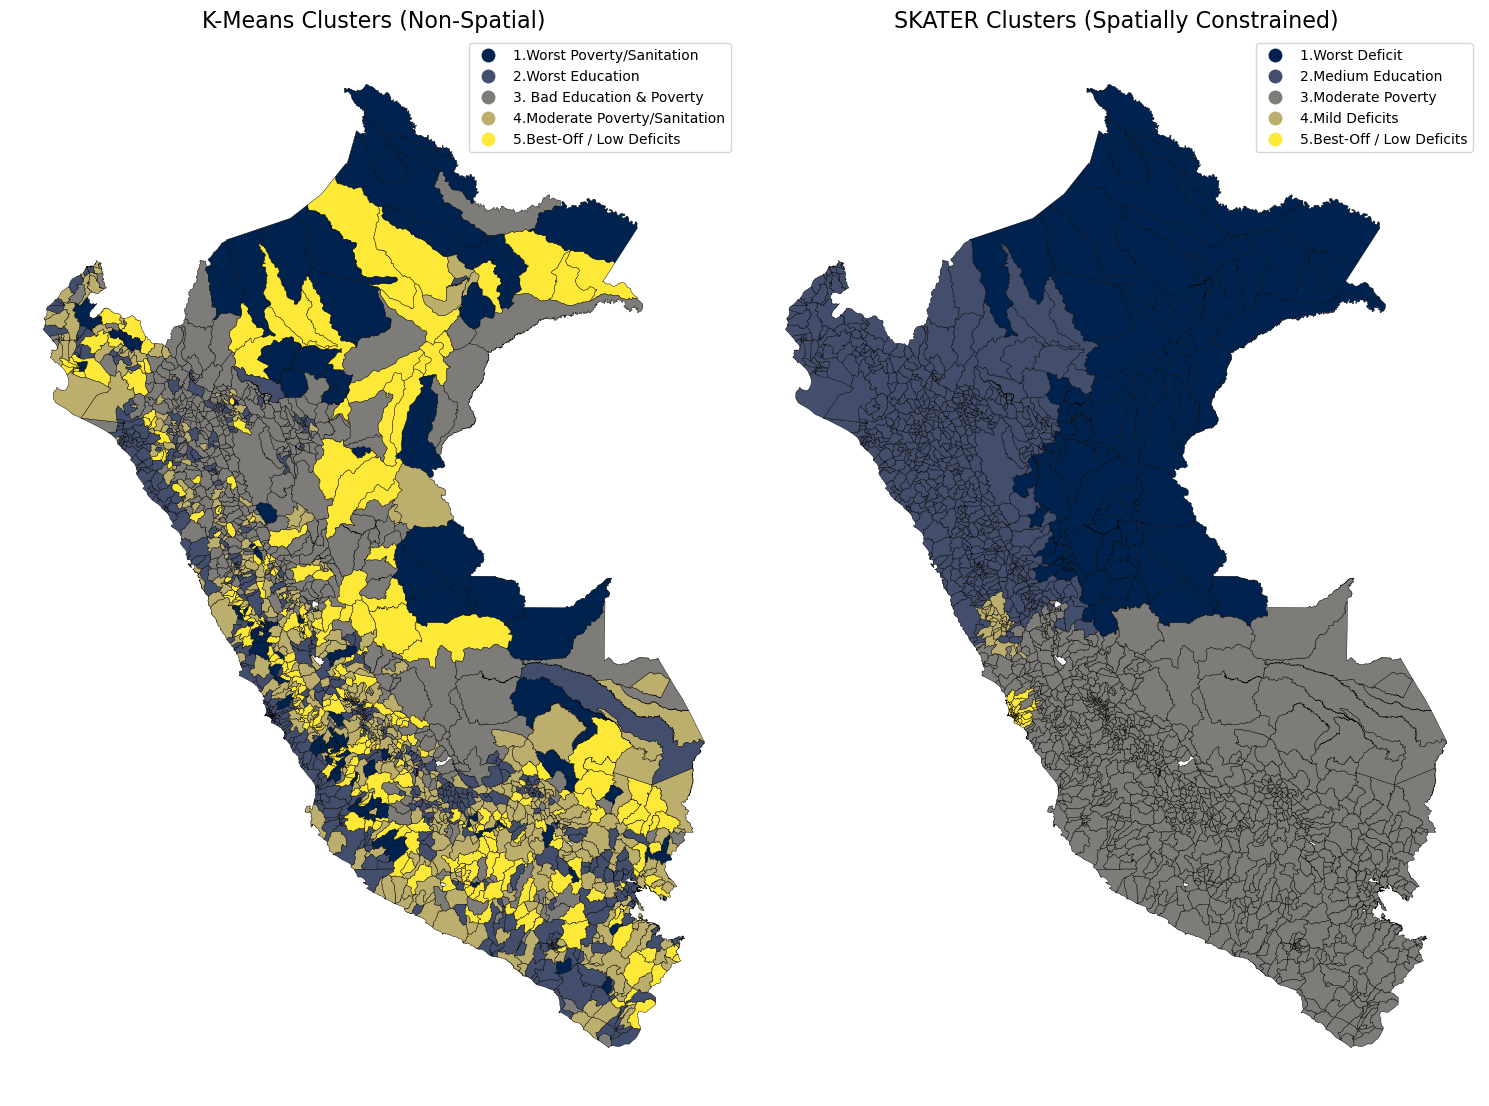

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 12))

# K-Means map
DisMap.plot(
    column='deficit_k5_labels',
    cmap='cividis',
    categorical=True,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=axes[0]
)
axes[0].set_title('K-Means Clusters (Non-Spatial)', fontsize=16)
axes[0].set_axis_off()

# SKATER map
DisMap.plot(
    column='deficit_skaterR_labels',
    cmap='cividis',
    categorical=True,
    legend=True,
    edgecolor='black',
    linewidth=0.3,
    ax=axes[1]
)
axes[1].set_title('SKATER Clusters (Spatially Constrained)', fontsize=16)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

#### Between Techniques

This stage is more challenging than the previous one. Here, the goal is to examine whether the results obtained through both methods can be interpreted in comparable terms. In other words:

> Which SKATER cluster shows the closest resemblance to a K-Means cluster, in statistical or informational terms?

First, let me concatenate my previous results, with some extra changes:

In [43]:
kmeans_means=DisMap.groupby("deficit_k5")[clusterNames].mean()
skater_means=DisMap.groupby("deficit_skaterR")[clusterNames].mean()

# Label rows to distinguish origin
kmeans_means.index = [f"K{i}" for i in kmeans_means.index]
skater_means.index = [f"S{i}" for i in skater_means.index]

# Combine both
between_ks = pd.concat([kmeans_means, skater_means])

between_ks

,Education_deficit,BasicNeeds_deficit,Sanitation_deficit
K0,0.576193,2.382523,3.954007
K1,-0.699371,-0.831340,-0.580727
K2,-0.182712,-0.010912,0.369425
K3,0.326380,1.075266,1.786395
K4,1.009179,0.531036,-0.194611
S0,-0.261468,0.103472,0.547342
S1,-0.159990,0.967597,2.412428
S2,0.506873,0.168872,0.059072
S3,1.163659,1.634777,1.001277
S4,-1.034751,-1.225515,-0.839518


Then, we can compute the distance matrix:

In [44]:
from scipy.spatial.distance import pdist,  squareform
# Compute distance matrix
dist_matrix = pdist(between_ks.values, metric='euclidean')


# Convert condensed distance matrix to square
dist_square = squareform(dist_matrix)

# Create a DataFrame with labels
dist_df = pd.DataFrame(dist_square, index=between_ks.index, columns=between_ks.index)

dist_df


,K0,K1,K2,K3,K4,S0,S1,S2,S3,S4
K0,0.000000,5.702613,4.376495,2.543594,4.563608,4.183434,2.218208,4.480578,3.102073,6.212162
K1,5.702613,0.000000,1.357507,3.207893,2.219075,1.529109,3.533566,1.692569,3.472082,0.578642
K2,4.376495,1.357507,0.000000,1.856546,1.425640,0.225701,2.265361,0.777283,2.218163,1.913836
K3,2.543594,3.207893,1.856546,0.000000,2.164898,1.680833,0.800041,1.959023,1.276910,3.747224
K4,4.563608,2.219075,1.425640,2.164898,0.000000,1.532268,2.890362,0.669200,1.634704,2.771105
S0,4.183434,1.529109,0.225701,1.680833,1.532268,0.000000,2.058047,0.912706,2.140546,2.070641
S1,2.218208,3.533566,2.265361,0.800041,2.890362,2.058047,0.000000,2.573122,2.046588,4.018719
S2,4.480578,1.692569,0.777283,1.959023,0.669200,0.912706,2.573122,0.000000,1.862256,2.264593
S3,3.102073,3.472082,2.218163,1.276910,1.634704,2.140546,2.046588,1.862256,0.000000,4.050037
S4,6.212162,0.578642,1.913836,3.747224,2.771105,2.070641,4.018719,2.264593,4.050037,0.000000


This subsetting helps see the distances (the smaller the number the more similar $K_i$ to $S_i$):

In [45]:
# Select K rows and S columns
k_labels = [label for label in dist_df.index if label.startswith('K')]
s_labels = [label for label in dist_df.columns if label.startswith('S')]

ks_df = dist_df.loc[k_labels, s_labels]
ks_df


,S0,S1,S2,S3,S4
K0,4.183434,2.218208,4.480578,3.102073,6.212162
K1,1.529109,3.533566,1.692569,3.472082,0.578642
K2,0.225701,2.265361,0.777283,2.218163,1.913836
K3,1.680833,0.800041,1.959023,1.276910,3.747224
K4,1.532268,2.890362,0.669200,1.634704,2.771105


This may help you see which cluster may be labelled similary, and which uniquely:

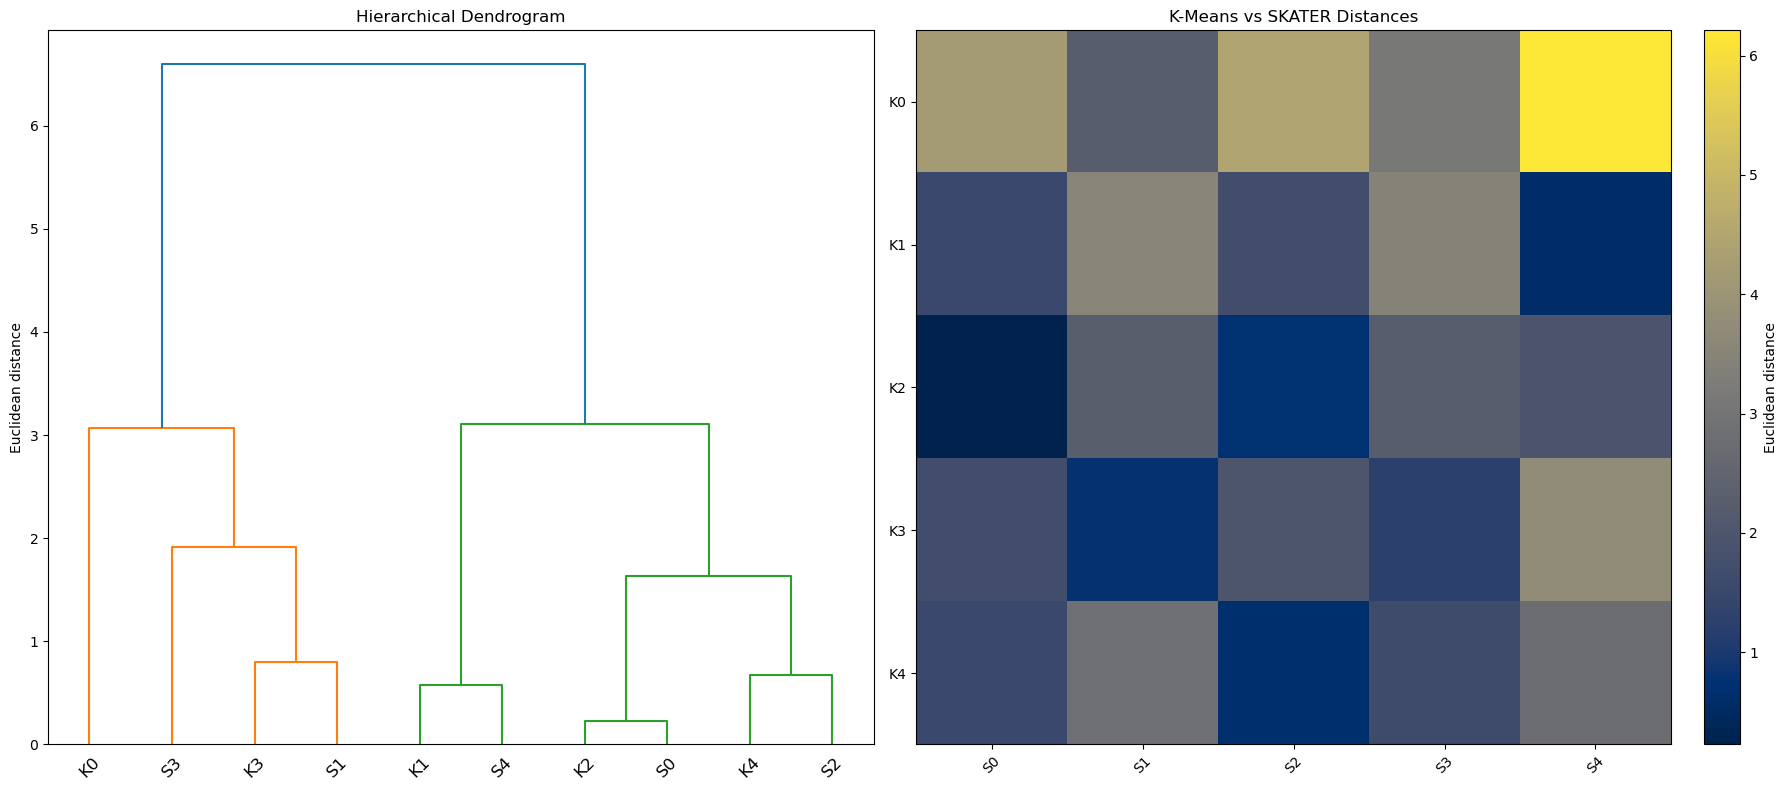

In [46]:
import numpy as np # <-- Need this for linkage and np.ix_ if you use it later
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# --- Step 1: Linkage (Requires numpy import for linkage) ---
# NOTE: dist_matrix was defined in the first code block
linkage_matrix = linkage(dist_matrix, method='ward')

# --- Step 2: Prepare Distance Subset for Heatmap (Using previous result) ---
# Use the DataFrame calculated in the first block: ks_df
ks_dist = ks_df.values # Get the array of distances
k_labels = ks_df.index.tolist() # Get the row labels
s_labels = ks_df.columns.tolist() # Get the column labels

# --- Step 3: Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- Dendrogram on left ---
dendrogram(linkage_matrix, labels=between_ks.index, leaf_rotation=45, ax=axes[0])
axes[0].set_title("Hierarchical Dendrogram")
axes[0].set_ylabel("Euclidean distance")

# --- Heatmap on right ---
im = axes[1].imshow(ks_dist, cmap='cividis', aspect='auto')
axes[1].set_xticks(range(len(s_labels)))
axes[1].set_xticklabels(s_labels, rotation=45)
axes[1].set_yticks(range(len(k_labels)))
axes[1].set_yticklabels(k_labels)
axes[1].set_title("K-Means vs SKATER Distances")
cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label("Euclidean distance")

plt.tight_layout()
plt.show()


Using **heatmaps and dendrograms based on cluster distances** provides a clear visual summary of the similarity structure across methods, helping to quickly identify which K-Means and SKATER clusters are closest in terms of their mean deficits. These visualizations are particularly useful for exploratory comparison, showing patterns and potential correspondences between spatially unconstrained and spatially constrained partitions.

However, caution is needed when **assigning labels across techniques**. While some clusters naturally correspond (e.g., a worst-off K-Means cluster and a highly deprived SKATER cluster), forcing a one-to-one match is not always warranted. The focus should remain on understanding the relative distances and patterns, rather than imposing exact equivalences that may oversimplify the underlying multidimensional differences.






## Conventional Regression


Let's represent this model:


$$\text{BasicNeeds\_deficit\_pct} = \beta_0 + \beta_1 (\text{Sanitation\_deficit\_pct}) + \beta_2 (\text{Education\_deficit\_pct}) + \epsilon$$


The model attempts to predict the **Percentage of Population with Unmet Basic Needs (NBI)** using the **Percentage with Completed High-School Education** and the **Percentage of Households Lacking Sanitation**.

These models share several arguments. Let me prepare a dict of arguments:


In [47]:
dep_var_name='BasicNeeds_deficit_pct'
ind_vars_names=['Sanitation_deficit_pct', 'Education_deficit_pct']

argsRegre=dict(
    y=DisMap[dep_var_name], # Dependent variable
    x=DisMap[ind_vars_names], # Independent variables
    name_y=dep_var_name, # Dependent variable name
    name_x=ind_vars_names, # Independent variable name
    name_ds='DisMap') # name of data set

Now, we run the regression:

In [48]:
from pysal.model import spreg

ols_model = spreg.OLS(**argsRegre)

### this is the regression output
ols_model.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,11.324092,0.875901,12.928504,0.0
1,Sanitation_deficit_pct,0.67285,0.018061,37.254444,0.0
2,Education_deficit_pct,0.356129,0.018802,18.941524,0.0


We see our Xs have positive significan effects on Y.

If we wish to compare this output with other regression models, you may use:

* For **non-nested models**:

In [49]:
ols_model.ar2 # closer to 1 the better

np.float64(0.5310496027266105)

In [50]:
ols_model.aic # smaller the better

np.float64(14752.274640949285)

In [51]:
np.sqrt(ols_model.sig2) # S.E. of Regression - # smaller the better

np.float64(12.513755361440424)

* For **nested models**:

In [52]:
ols_model.f_stat[0],ols_model.f_stat[1]<0.05 # is significant?

(np.float64(1058.6818610892403), np.True_)

| Test | Null Hypothesis ($H_0$) | Comparison Method | Key Concept |
| :--- | :--- | :--- | :--- |
| **F-statistic** | All $X$ coefficients are zero (comparing the model to a null model with only a constant). | Reject $H_0$ if **$p$-value** is low. | **Overall Model Significance** |

In simple terms, when comparing different models:

> The model with the **lowest AIC**, the **highest Adjusted $R^2$**, and the **lowest S.E. of Regression** is generally preferred, given the **F-Statistics is significant**.


### OLS diagnostics

WE need to verify post-hoc if some issues arised that would weaken model usefulness.

The object **ols_model** has key information on this:

In [53]:
# is there collinearity?
ols_model.mulColli>=30

False

In [54]:
# is the normality?
ols_model.jarque_bera['pvalue']>0.05

np.False_

In [55]:
# is there homocedasticity?
ols_model.koenker_bassett['pvalue']>0.05

np.False_

If we stay with conventional regression (OLS), we should deal with lack of normality and homocedasticity.


### Spatial Regression need?

Let's re run the previous code, but requesting **spatial disgnostics**, for that we input the adjacency matrix (peru_perim_graph)

But first, let me make a new copy and update the common arguments:

In [56]:
argsRegre_W=argsRegre.copy() # copied dict

# new arguments
W_info=dict(
    w=peru_perim_graph,       # REQUIRED: Defines neighbor relationships for spatial diagnostics
    name_w='peru_perim_graph') # Name of the weights matrix

# copied dict plus new  arguments
argsRegre_W.update(W_info)

Let's re run!

In [57]:
ols_model_with_W = spreg.OLS( **argsRegre_W,
                   spat_diag=True,         # generates spatial tests
                   robust='white'          # essential to deal with OLS diagnostic problems
                   )

Given we requested spatial diagnostics (post-hoc), let's see the **Durbin Joint Test**:

In [58]:
# Do any of the regression terms (X, Y, error) is being affected by behavior of neighbors
ols_model_with_W.lm_spdurbin[1]<0.05

np.True_

The significance of the Joint test for SDM (our result: $p < 0.05$) confirms a crucial point:

>The OLS model is statistically wrong (misspecified). A spatial model is needed. This is telling us that location is playing in at least one of these terms: X (independent variables), Y (dependent variables), $\epsilon$ (error term).

These are possible regression models for each case:


* **SAR**: The value of Y in neighboring locations directly affects your Y.

In [59]:
ols_model_with_W.rlm_lag[1]<0.05

np.False_

* **SEM**: A location's error is dependent on its neighbors' errors, meaning unobserved influences spread across space

In [60]:
ols_model_with_W.rlm_error[1]<0.05

np.True_

* **SLX**: The values of X in neighboring locations affect your Y.

In [61]:
ols_model_with_W.rlm_wx[1]<0.05

np.True_

Let's start the journey! (SAR was not good, but will be part of the journey).

## Spatial Regression: one term at a time

### SAR

The Spatial Autoregressive (SAR) model can be computed like this:


In [63]:
SAR_model = spreg.GM_Lag(
    **argsRegre_W,
    spat_impacts='simple',
    robust='white') # we knew there is Heteroskedasticity

Now, let's see the regression coefficients:

In [64]:
SAR_model.output # this is rho: W_BasicNeeds_deficit_pct

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,9.846374,1.04975,9.379733,0.0
1,Sanitation_deficit_pct,0.654366,0.018453,35.461452,0.0
2,Education_deficit_pct,0.335317,0.023661,14.171455,0.0
3,W_BasicNeeds_deficit_pct,0.069651,0.035327,1.971624,0.048653


#### Interpretation

This may help interpretation. We have:


| Row | Variable Name | Coefficient (Raw $\beta$ or $\rho$) | P-Value (Prob) | Interpretation of Significance |
| :--- | :--- | :--- | :--- | :--- |
| **0** | **CONSTANT** | $9.767$ | $0.01$ | Significant: The baseline deficit is 9.77%. |
| **1** | $\mathbf{X_1}$ **Sanitation** | **$0.653$** ($\beta_1$) | $0.02$ | Significant: Your own sanitation deficit has a positive initial effect on your own basic needs deficit. |
| **2** | $\mathbf{X_2}$ **Education** | **$0.339$** ($\beta_2$) | $0.02$ | Significant: Your own education deficit has a positive initial effect on your own basic needs deficit. |
| **3** | $\mathbf{\rho W Y}$ | **$0.069$** ($\rho$) | **$0.051$** | **Marginally Significant:** The spatial contagion effect is present. |


At a strict $\alpha=0.05$ level, you would **fail to reject the null hypothesis ($H_0: \rho = 0$)**, suggesting the spatial lag term is **not statistically significant**.

#### Impacts

In a SAR model, the coefficients ($\beta$) are not direct marginal effects because a change in $X$ in one location affects the dependent variable in all other locations (due to the feedback loop of $\rho WY$). Therefore, the impacts are broken down:

In [65]:
from spreg.sputils import spmultiplier

# Compute multipliers
impacts = spmultiplier(peru_perim_graph, SAR_model.rho[0])

# Get relevant betas (drop intercept and rho)
betas = SAR_model.betas[1:-1].flatten()

# Build impact table
effects_df = pd.DataFrame({
    'Variable': ind_vars_names,
    'Direct': betas * impacts['adi'],
    'Indirect': betas * impacts['aii'],
    'Total': betas * impacts['ati']
})

# here you are
effects_df


,Variable,Direct,Indirect,Total
0,Sanitation_deficit_pct,0.654366,0.048989,0.703355
1,Education_deficit_pct,0.335317,0.025104,0.360420



**Sanitation_deficit_pct**

* **Direct effect (0.653):**
  If the share of households without adequate sanitation in a city increases by **1 percentage point**, the share of the population with *unsatisfied needs* in that city increases by **0.65 percentage points**, on average.
  → This captures the *within-city* marginal impact.

* **Indirect effect (0.048):**
  The same 1-point increase also raises unsatisfied needs in *neighboring cities* by about **0.05 percentage points**, on average, due to spatial spillovers.
  → Poor sanitation in one city slightly worsens deprivation nearby (perhaps via migration, shared infrastructure, or regional contagion of poverty).

* **Total effect (0.701):**
  Overall, each additional point of sanitation deficit in one city leads to about **0.7 percentage points more unsatisfied needs** in the regional system (the city + its neighbors).


**Education_deficit_pct**

* **Direct effect (0.339):**
  A 1-point increase in the local education deficit raises unsatisfied needs locally by **0.34 points**, on average.

* **Indirect effect (0.025):**
  It also raises deprivation in nearby cities by **0.025 points**, on average.

* **Total effect (0.364):**
  Overall regional effect ≈ **0.36 percentage points** increase in unsatisfied needs for each point increase in education deficit.

#### Diagnostics for remaining Spatial Dependence

In [66]:
#Anselin-Kelejian Test
SAR_model.ak_test, SAR_model.ak_test[1]<0.05

((np.float64(133.04811358387633), np.float64(8.824699102176221e-31)), np.True_)

Then,

> **The SAR model has NOT fully corrected the spatial dependence problem, as the model residuals are still spatially correlated.**

Let's go to SEM.

### SEM


The **Spatial Error Model (SEM)** can be computed like this:


In [67]:
# GM - uses a Generalized Moments (GM) estimator that is robust to heteroskedasticity.
SEM_model = spreg.GM_Error_Het(**argsRegre_W)

Now the regression coefficients:

In [68]:
SEM_model.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,16.44423,1.151062,14.286133,0.0
1,Sanitation_deficit_pct,0.746347,0.014903,50.080382,0.0
2,Education_deficit_pct,0.199123,0.021099,9.437516,0.0
3,lambda,0.781231,0.018614,41.969137,0.0


#### Interpretation and Impacts

The dependent variable is the Basic Needs Deficit ($Y$).

| Row | Coefficient | Value | P-Value | Interpretation (Straightforward) |
| :--- | :--- | :--- | :--- | :--- |
| **0** | **CONSTANT** | $16.29$ | $0.01$ | The baseline deficit is $16.29\%$ when all deficits are zero. |
| **1** | $\beta_1$ (Sanitation) | $\mathbf{0.745}$ | $0.02$ | **Direct Impact:** A one-unit increase in a district's own Sanitation Deficit increases its Basic Needs Deficit by $\mathbf{0.745}$ units. |
| **2** | $\beta_2$ (Education) | $\mathbf{0.204}$ | $0.03$ | **Direct Impact:** A one-unit increase in a district's own Education Deficit increases its Basic Needs Deficit by $\mathbf{0.204}$ units. |
| **3** | $\mathbf{\lambda}$ (Error Lag) | $\mathbf{0.781}$ | $0.00$ | **Strong positive spatial autocorrelation in the residuals** — unobserved factors influencing basic-needs deficit are highly spatially clustered. |

Notice that the $\beta$s are the direct and TOTAL impact. NO further computations is needed.

As you may have noticed, SEM is likely a better fit for our data than the SAR model.

### SLX

The Spatial Lag of X (SLX) model can be computed like this:

In [69]:
slx_model = spreg.OLS(**argsRegre_W,
    spat_diag=True,
    slx_lags=1,robust="white"
)
slx_model.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,7.267313,1.017762,7.140485,0.0
1,Sanitation_deficit_pct,0.726302,0.020337,35.713867,0.0
2,Education_deficit_pct,0.198728,0.029773,6.674711,0.0
3,W_Sanitation_deficit_pct,-0.11221,0.031389,-3.574844,0.000359
4,W_Education_deficit_pct,0.271577,0.037106,7.318959,0.0


#### Interpretation and Impacts

Given that SLX models:


$$
y = X\beta + WX\theta + \varepsilon
$$

* **Direct effect** → the impact of a variable in district *i* on its own outcome (*β*).
* **Indirect effect (spillover)** → the impact of that variable in *neighboring districts* on district *i*’s outcome (*θ*).
* **Total effect** → the sum (*β + θ*), representing the **overall regional impact** of a change in that variable.


| Variable               | Direct effect (β) | Indirect effect (θ) | Total effect (β + θ) | Significance  |
| ---------------------- | ----------------: | ------------------: | -------------------: | ------------- |
| **Sanitation deficit** |            0.7247 |             −0.1123 |           **0.6124** | All p < 0.001 |
| **Education deficit**  |            0.2035 |             +0.2694 |           **0.4729** | All p < 0.001 |

We see that:

> **Direct effects** show that both sanitation and education deficits significantly increase local deprivation: a one-unit rise in sanitation deficit raises Basic Needs Deficit by **0.725 points**, while a comparable increase in education deficit raises it by **0.203 points**.
>
> **Indirect (spillover) effects** indicate that neighboring conditions also matter. Higher **education deficits in adjacent districts** raise local deprivation (+0.269), revealing a **positive spatial spillover**—deprivation clusters regionally through educational disadvantage. Conversely, **neighboring sanitation deficits** exhibit a **negative spillover** (−0.112), suggesting **spatial compensation or policy substitution**, where areas surrounded by worse sanitation conditions may receive offsetting resources or attention.
>
> **Total effects** confirm that sanitation deficits remain the strongest overall determinant (0.612), but **educational deficits—local and neighboring combined—exert nearly half as much total impact (0.473)**, underscoring the regional diffusion of educational deprivation.



* Are we missing something given we have controlled spatial dependence in X?

#### Diagnostic for remaining spatial effects

| Test Result | $RLM_{\text{Error}}$ (p-value $\ge 0.05$) | $RLM_{\text{Lag}}$ (p-value $< 0.05$) | Interpretation of Remaining Dependence | Recommended Model |
| :--- | :--- | :--- | :--- | :--- |
| **Case 1** | Not Significant | **Significant** | **Dominant Spatial Lag:** The model is missing the Endogenous Spatial Lag term ($\rho \mathbf{W}\mathbf{Y}$). | **Spatial Durbin Model (SDM)** |
| **Case 2** | **Significant**  | Not Significant | **Dominant Spatial Error:** The model is missing the Spatial Error term ($\lambda \mathbf{W}\mathbf{u}$). | **SLX-Error Model** |
| **Case 3** | **Significant**  | **Significant**  | **Both Lag and Error Significant:** The model is missing both terms. | **Spatial Autocorrelation Model (SAC)** |

In case none were significant, SLX would be the right model.

Here, SLX informs we have the first option:

In [70]:
# need to control error term? / # need to control Y?
slx_model.rlm_error[1]<0.05 , slx_model.rlm_lag[1]<0.05

(np.False_, np.True_)

## Spatial Regression: more than one term at at time

### SLX-Error


The Spatially Lagged X with Spatial Error Model (**SLX-Error Model**) is a hybrid spatial regression model designed to account for two distinct sources of spatial dependence simultaneously:

1.  **Exogenous Spatial Interaction (The SLX Component):** The influence of independent variables ($\mathbf{X}$) in neighboring areas directly affecting the dependent variable ($\mathbf{Y}$) in the local area.
2.  **Unmodeled Spatial Dependence (The Error Component):** The spatial clustering of unobserved factors that are not captured by the independent variables, which shows up in the error term.

The SLX-Error model essentially takes the standard **Spatial Error Model (SEM)** and adds the **Spatially Lagged X ($\mathbf{W X}$) terms**.

The SLX-Error model is defined by the following two equations:

$$
\begin{aligned}
\mathbf{Y} &= \mathbf{X}\boldsymbol{\beta} + \mathbf{W X}\boldsymbol{\theta} + \boldsymbol{\mu} \\
\boldsymbol{\mu} &= \lambda \mathbf{W}\boldsymbol{\epsilon} + \boldsymbol{\epsilon}
\end{aligned}
$$

We can easily compute it like this:

In [71]:
from pysal.model.spreg import GM_Error_Het

SLXE_model = GM_Error_Het(**argsRegre_W,
                          slx_lags=1              # Adds the W*X terms
                         )
## se the output
SLXE_model.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,13.23229,1.958641,6.755852,0.0
1,Sanitation_deficit_pct,0.735855,0.015528,47.388725,0.0
2,Education_deficit_pct,0.206137,0.021698,9.500463,0.0
3,W_Sanitation_deficit_pct,-0.085269,0.034356,-2.481937,0.013067
4,W_Education_deficit_pct,0.103039,0.038306,2.68986,0.007148
5,lambda,0.770799,0.01942,39.69056,0.0



#### Interpretation  and Impacts

**Model:** $\mathbf{Y} = \mathbf{X}\beta + \mathbf{W}\mathbf{X}\theta + \lambda \mathbf{W}\mathbf{u} + \epsilon$

The dependent variable is the **Basic Needs Deficit (%)**. Interpretation assumes a **one–percentage-point increase** in the independent variable ((X)).

| Coefficient / Impact                            | Value      | P-Value       | Interpretation (Effect on Basic Needs Deficit, in Percentage Points)                                                                                                                 |
| :---------------------------------------------- | :--------- | :------------ | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Direct Impact $\beta_1$ — Sanitation**      | **0.734**  | 0.02          | A 1 pp increase in the district’s *Sanitation Deficit* raises its *Basic Needs Deficit* by **0.734 pp**, indicating a strong local effect.                                           |
| **Direct Impact $\beta_2$ — Education**       | **0.211**  | 0.03          | A 1 pp increase in the district’s *Education Deficit* raises its *Basic Needs Deficit* by **0.211 pp**, showing a smaller but significant local effect.                              |
| **Indirect Impact $\theta_1$ — W_Sanitation** | **–0.085** | 0.014         | A 1 pp increase in *neighboring districts’* Sanitation Deficit **reduces** local Basic Needs Deficit by **0.085 pp**, suggesting mild compensatory or competitive spatial responses. |
| **Indirect Impact $\theta_2$ — W_Education**  | **+0.101** | 0.008         | A 1 pp increase in *neighboring districts’* Education Deficit **raises** local Basic Needs Deficit by **0.101 pp**, indicating spatial diffusion of educational deprivation.         |
| **Total Impact (Sanitation)**                   | **0.650**  | *Significant* | A uniform 1 pp increase in Sanitation Deficit across all districts raises the regional average Basic Needs Deficit by **0.650 pp**.                                                  |
| **Spatial Error Coefficient $\lambda$**       | **0.770**  | 0.00          | Strong residual dependence: roughly **77% of unobserved influences** are spatially correlated, indicating persistent regional clustering in unmeasured deprivation factors.          |

---

#### Key Insights

| Variable               | $\theta$ (Indirect Impact)             | Interpretation of the Spatial Process                                                                                                                                                                                                                                                                                                                                    | Policy Implication                                                                                                                                                                                                                                              |
| ---------------------- | ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Sanitation Deficit** | **–0.085 (Negative Spillover)** | **Localized Adjustment or Resource Buffer:** Higher sanitation deficits in neighboring districts are associated with slightly lower local basic-needs deficits. This implies adaptive or compensatory responses, where districts intensify local efforts as surrounding conditions worsen. The process reflects **localized dynamics** rather than widespread contagion. | **Local Priority with Regional Awareness:** Sanitation deprivation is primarily locally driven. Policies should **prioritize district-level interventions** while maintaining **minimal regional coordination** to prevent resource competition or duplication. |
| **Education Deficit**  | **+0.101 (Positive Spillover)** | **Contagion or Regional Pressure:** Higher education deficits in neighboring districts amplify local deprivation, reflecting spatial clustering of disadvantage through shared educational systems, teacher availability, or funding dependencies.                                                                                                                       | **Regional Coordination is Essential:** Education deficits exhibit strong regional coupling. Policy responses must include **inter-district coordination** and **joint education investment planning** to reduce regional inequality traps.                     |


These results reveal **dual spatial dynamics**:

* *Sanitation deficits* act locally with compensatory adjustments.
* *Education deficits* diffuse regionally, reinforcing structural inequality.


### SAC


The SAC model combines **two spatial processes**:

$$
y = \rho W y + X\beta + u, \quad u = \lambda W u + \varepsilon
$$

* $\rho$ → spatial lag of the dependent variable (W y)
* $\lambda$ → spatial error (W u)
* $\beta$ → coefficients on observed covariates (X)

We can compute it like this:


In [72]:
sac_model =spreg.GM_Combo_Het(**argsRegre,
    w=peru_perim_graph,
    name_w='peru_perim_graph')

# results:
sac_model.output

,var_names,coefficients,std_err,zt_stat,prob
0,CONSTANT,15.867529,2.105258,7.537093,0.0
1,Sanitation_deficit_pct,0.743425,0.015791,47.079602,0.0
2,Education_deficit_pct,0.206578,0.021193,9.747252,0.0
3,W_BasicNeeds_deficit_pct,0.01037,0.04457,0.232659,0.816026
4,lambda,0.802512,0.024088,33.315979,0.0


#### Interpretation

We see that:

| Variable                                             | Interpretation                                                                                                                                                                                                        |
| :--------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Sanitation_deficit_pct (β = 0.742, p < 0.001)**    | **Dominant direct effect:** Local sanitation deficits strongly increase Basic Needs Deficit.                                                                                                                          |
| **Education_deficit_pct (β = 0.211, p < 0.001)**     | **Significant direct effect:** Local education deficits also increase Basic Needs Deficit.                                                                                                                            |
| **W_BasicNeeds_deficit_pct (ρ = 0.0098, p = 0.825)** | **Insignificant endogenous feedback:** Neighboring districts’ Basic Needs Deficit has **no measurable direct effect** on the local outcome. The dependent variable does not “diffuse” across neighbors in this model. |
| **λ (lambda = 0.803, p < 0.001)**                    | **Strong spatial error dependence:** Unobserved shocks remain highly correlated across districts, indicating that latent regional factors drive much of the spatial structure.                                        |
Then,

> Our SAC model results strongly imply that the simpler Spatial Error Model (SEM) is the statistically correct and more parsimonious choice.

### SDM

The Spatial Durbin Model (SDM) is a model that combines the SAR structure with the **spatial lag of the independent variables** (the $WX\theta$ term).

* **When to Use It (Diagnostics):** When both the **Robust LM (error)** and the **Robust LM WX test** are significant (as they are in our case).
* **Model Structure:**
    $$Y = \rho W Y + X\beta + W X \theta + \epsilon$$
    * $\rho W Y$: Neighbors' deficit influences your deficit.
    * $W X \theta$: Neighbors' **independent variables** (Sanitation and Education deficits) influence your deficit.


In [74]:
sdm_model = spreg.GM_Lag(**argsRegre_W,
    slx_lags=1, robust="white"
)
print(sdm_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES WITH SLX (SPATIAL DURBIN MODEL)
----------------------------------------------------------------------------------
Data set            :      DisMap
Weights matrix      :peru_perim_graph
Dependent Variable  :BasicNeeds_deficit_pct                Number of Observations:        1869
Mean dependent var  :     38.5762                Number of Variables   :           6
S.D. dependent var  :     18.2736                Degrees of Freedom    :        1863
Pseudo R-squared    :      0.8075
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.75228         1.15703         0.65018   

The result of SDM is unstable. Notice **rho outside the boundary**.


#### The Common Factor Hypothesis (CFH) Test for WX

| CFH Test Result | Statistical Decision | Model Relationship | Interpretation                                                                                                                                                      | Practical Conclusion                                                                               |
| :-------------- | :------------------- | :----------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------ | :------------------------------------------------------------------------------------------------- |
| **p > 0.05**    | Fail to reject H₀    | SDM ≈ SEM          | The spatially lagged independent variables (WX) do **not add significant explanatory power**. Their effects are already captured through the spatial error process. | **Simplify to SEM** — the SDM can be reduced to a Spatial Error Model without loss of information. |
| **p < 0.05**    | Reject H₀            | SDM ≠ SEM          | The WX terms capture **additional spatial spillovers** that are not explained by spatial error dependence.                                                          | **Keep SDM** — the richer specification is justified and necessary to model spatial spillovers.    |


Let's check:

In [75]:
# Common Factor Hypothesis test
sdm_model.cfh_test[1]>0.05

np.True_

> CFH test result: **p > 0.05** → Fail to reject H₀
> Therefore, the SDM simplifies to **SEM** — the WX terms are not statistically needed.

### COMBO

In [76]:
combo_model=spreg.GM_Combo_Het(**argsRegre,
    w=peru_perim_graph,slx_lags=1,
    name_w='peru_perim_graph')
print(combo_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS- GM-COMBO MODEL (HET) WITH SLX (GNSM)
--------------------------------------------------------------------------------
Data set            :      DisMap
Weights matrix      :peru_perim_graph
Dependent Variable  :BasicNeeds_deficit_pct                Number of Observations:        1869
Mean dependent var  :     38.5762                Number of Variables   :           6
S.D. dependent var  :     18.2736                Degrees of Freedom    :        1863
Pseudo R-squared    :      0.8047
Spatial Pseudo R-squared:  0.2124
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.88846         1.82730 

#### Caution

While the GM-COMBO (HET) with SLX (GNSM) model provides statistically significant results across all parameters and achieves a high overall fit (Pseudo R² = 0.80), this specification is **not retained for substantive interpretation**. The COMBO model combines two distinct spatial processes — a spatially lagged dependent variable (ρ) and spatially autocorrelated errors (λ). Although this formulation captures both diffusion and residual clustering, it also makes the spatial mechanisms **difficult to disentangle** and the coefficients **harder to interpret in policy terms**.

To emphasize **interpretability and policy relevance**  attention should mainly focused on simpler models.

In [77]:
# List all variables ending with "_model"
model_list = [name for name in globals() if name.endswith('_model')]


model_names = ['ols_model', 'SAR_model', 'SEM_model', 'SLXE_model',
               'sdm_model', 'slx_model', 'sac_model', 'combo_model']

# Prepare a summary list
summary = []

for name in model_names:
    model = globals()[name]  # get the model object
    # Get AIC if available
    aic = getattr(model, 'aic', None)
    # Get pseudo R2
    r2 = getattr(model, 'r2', None)
    # Get spatial pseudo R2 if available
    pr2 = getattr(model, 'pr2', None)
    summary.append({
        'Model': name,
        'AIC': aic,
        'R2': r2,
        'Spatial Pseudo R2': pr2
    })

# Convert to DataFrame for nice display
import pandas as pd
summary_df = pd.DataFrame(summary)
print(summary_df)


         Model           AIC        R2  Spatial Pseudo R2
0    ols_model  14752.274641  0.531552                NaN
1    SAR_model           NaN       NaN           0.568968
2    SEM_model           NaN       NaN           0.512602
3   SLXE_model           NaN       NaN           0.536911
4    sdm_model           NaN       NaN           0.807480
5    slx_model  14689.703501  0.547943                NaN
6    sac_model           NaN       NaN           0.520490
7  combo_model           NaN       NaN           0.804701


Selecting the appropriate spatial model requires careful judgment; best-fit statistics should not be the sole criterion. Complex specifications, such as the Spatial Durbin Model (SDM), can produce inflated fit values (e.g., Pseudo-R² $\approx 0.81$ in our SDM) often driven by interdependent spatial terms. Crucially, our SDM estimation yielded an **unstable spatial lag parameter ($\rho > 1$)**, rendering its calculated impacts unreliable and policy-irrelevant.

For robust policy work, interpretability and causal clarity matter more than marginal gains in fit. We therefore prioritize a model specification that directly addresses the significant spatial processes identified by our diagnostics ($\mathbf{W}\mathbf{X}\theta$ spillovers and $\lambda \mathbf{W}\mathbf{u}$ error clustering) while excluding the unstable endogenous feedback term ($\rho \mathbf{W}\mathbf{Y}$).

**Practically, this leads to the Spatial Lag of X with Error (SLX-Error) model.** This specification isolates the distinct intervention effects (direct effects $\mathbf{X}\beta$ and cross-boundary spillovers $\mathbf{W}\mathbf{X}\theta$) while statistically controlling the high degree of unobserved regional structure ($\lambda \approx 0.77$). This approach provides the clearest and most statistically sound basis for translating our deficit findings into actionable policy guidance.
